<a href="https://colab.research.google.com/github/Ujjwalsharma7/Microsoft-Clone/blob/main/stegano32x32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf 
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models 
import tensorflow.keras.optimizers as optim 


import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import random

import warnings 


warnings.filterwarnings("ignore")

train_images = []
test_images = []

In [3]:
cifar100 = tf.keras.datasets.cifar100
(train_images,_) , (test_images,_) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [4]:
IMG = (32,32,3)

In [5]:
def ConvBlock(x, num, filter, alpha=0.1, kernel=3, moment=0.9):
  for i in range(num):
    x=layers.Conv2D(filter, kernel, padding="same" )(x)
    x=layers.BatchNormalization(momentum=moment)(x)
    x=layers.LeakyReLU(alpha)(x)
  return x

def operation(inp, num=6, filter=64, start_kernel=7, kernel=3, moment=0.9, alpha=0.1 , gf=2):
  x = ConvBlock(inp, 1, filter, alpha, kernel, moment)
  for _ in range(num):
      filter = filter*gf
      x = ConvBlock(x, num, filter)
  x = ConvBlock(x, 1, 3)
  return x

def Stegnography(inp1, inp2, num:list=[2,2,3], filter=32, start_kernel=7, kernel=3, moment=0.9, alpha=0.1, gf=2):
    inp1 = layers.Input(inp1)
    encoder = operation(inp1, num[0], filter, start_kernel, kernel, moment, alpha, gf)
    inp2 = layers.Input(inp2)
    x = layers.Concatenate()([inp2, encoder])
    intermediate = operation(x, num[1], filter, start_kernel, kernel, moment, alpha, gf)
    decoder =  operation(intermediate, num[2], filter, start_kernel, kernel, moment, alpha, gf)

    model = models.Model(inputs=[inp1, inp2], outputs=[intermediate, decoder], name="ma_chuda")
    return model

model = Stegnography(IMG,IMG)
model.summary() 





  

Model: "ma_chuda"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['batch_normalization[0][0

In [6]:
XIMG = []
XDUM = []
VIMG = []
VDUM = []

for _ in range(25000):
    imp = random.randint(0, 49000)
    dumb = train_images[imp]
    imp = train_images[imp+1]
  
    inpdum = dumb.reshape(IMG[0],IMG[1],IMG[2])
    inpsex = imp.reshape(IMG[0],IMG[1],IMG[2])
    XIMG.append(inpsex)
    XDUM.append(inpdum)

XDUM = np.array(XDUM)/255.0
XIMG = np.array(XIMG)/255.0


for _ in range(5000):
    dum = random.randint(0, 4900)
    imp = random.randint(0, 4900)

    dumb = test_images[dum]
    imp = test_images[imp]
    inputs = np.concatenate([dumb.reshape(IMG[0], IMG[1], IMG[2]), imp.reshape(IMG[0], IMG[1], IMG[2])], axis = 2)
    inpdum = dumb.reshape(IMG[0], IMG[1], IMG[2])
    inpsex = imp.reshape(IMG[0], IMG[1], IMG[2])
    VIMG.append(inpsex)
    VDUM.append(inpdum)

VDUM = np.array(VDUM)/255.0
VIMG = np.array(VIMG)/255.0


In [7]:
def psnr(img1, img2):
  return tf.image.psnr(img1, img2, max_val=255)

In [15]:

import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

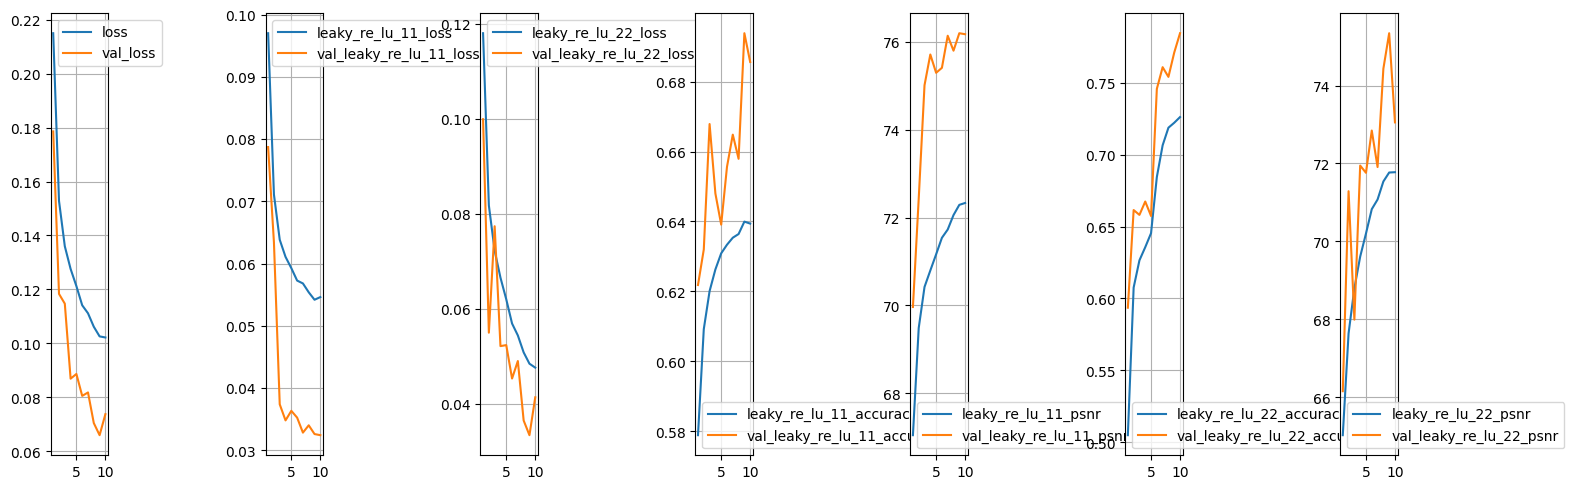

2500/2500 [==============================] - 99s 40ms/step - loss: 0.1022 - leaky_re_lu_11_loss: 0.0546 - leaky_re_lu_22_loss: 0.0476 - leaky_re_lu_11_accuracy: 0.6394 - leaky_re_lu_11_psnr: 72.3328 - leaky_re_lu_22_accuracy: 0.7261 - leaky_re_lu_22_psnr: 71.7764 - val_loss: 0.0737 - val_leaky_re_lu_11_loss: 0.0324 - val_leaky_re_lu_22_loss: 0.0413 - val_leaky_re_lu_11_accuracy: 0.6856 - val_leaky_re_lu_11_psnr: 76.1737 - val_leaky_re_lu_22_accuracy: 0.7845 - val_leaky_re_lu_22_psnr: 73.0551


In [16]:
callbacks_list = [PlotLearning()]
model.compile(loss="mae", optimizer=optim.Adam(learning_rate=1e-3), metrics=["accuracy", psnr])
history = model.fit([XIMG, XDUM], [XDUM, XIMG], epochs=10, verbose=1, batch_size = 10, validation_data=[[VIMG, VDUM], [VDUM, VIMG]], validation_batch_size=10, callbacks=callbacks_list)

In [17]:
history.history["loss"]

[0.21500732004642487,
 0.1528398096561432,
 0.13601906597614288,
 0.12760448455810547,
 0.12122374773025513,
 0.11412826180458069,
 0.11115681380033493,
 0.10616782307624817,
 0.10258781164884567,
 0.10218192636966705]

Text(0.5, 1.0, 'Output secret')

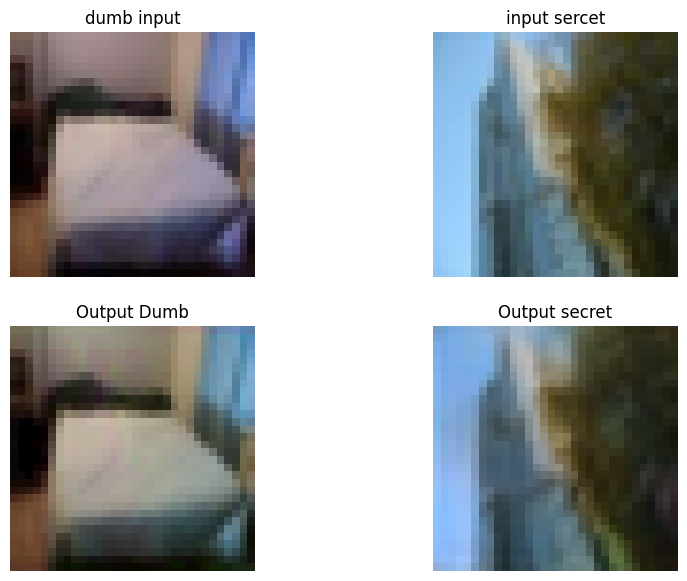

In [18]:
# code for displaying multiple images in one figure
c=579
#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))
out1, out2 = model([VDUM[c].reshape(-1, IMG[0], IMG[1], IMG[2]), VIMG[c].reshape(-1, IMG[0], IMG[1], IMG[2])])
# setting values to rows and column variables
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(VIMG[c].reshape(IMG[0], IMG[1], IMG[2]))

plt.axis('off')
plt.title("dumb input")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(VDUM[c].reshape(IMG[0], IMG[1], IMG[2]))
plt.axis('off')
plt.title("input sercet")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(np.array(out1).reshape(IMG[0], IMG[1], IMG[2]))
plt.axis('off')
plt.title("Output Dumb")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(np.array(out2).reshape(IMG[0], IMG[1], IMG[2]))
plt.axis('off')
plt.title("Output secret")


In [ ]:
model.save("/content/drive/MyDrive/ujjwal234_08.h5")